In [12]:
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from pyro.infer import MCMC, NUTS, HMC
from torch.distributions import MultivariateNormal
import pickle
import numpy as np
import pandas as pd
import os

In [13]:
train = pd.read_csv('TrainingData.txt',sep=' ',header=None)
measured_data = pd.read_csv('MeasuredData.txt',sep=' ',header=None)
print(train)
print(measured_data)

            0          1         2
0     0.08250   1.995262  1.000000
1     0.11450   1.995262  1.000000
2     0.02175   1.995262  1.000000
3     0.09300   1.995262  1.000000
4     0.02475   1.995262  1.000000
...       ...        ...       ...
1019  0.13000  31.622777  3.750403
1020  0.08575  31.622777  3.681079
1021  0.03200  31.622777  2.688466
1022  0.16175  31.622777  3.790666
1023  0.11775  31.622777  3.732877

[1024 rows x 3 columns]
           0         1
0    0.00000  1.010197
1    0.00025  0.988396
2    0.00050  0.985788
3    0.00075  1.011550
4    0.00100  0.998813
..       ...       ...
617  0.24900  3.478459
618  0.24925  3.900490
619  0.24950  4.192470
620  0.24975  3.739064
621  0.25000  3.970118

[622 rows x 2 columns]


In [14]:
batch_size = 40
training_set = DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(train.loc[:, :1].values).float(), torch.from_numpy(train.loc[:,2].values)), batch_size=batch_size, shuffle=True)

In [15]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, regularization_param, regularization_exp):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers-1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        #self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        #torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss


In [16]:
network = NeuralNet(input_dimension=2, 
                    output_dimension=1, 
                    n_hidden_layers=4, 
                    neurons=30,
                    regularization_param=0.01, 
                    regularization_exp=2)
optimizer = optim.Adam(network.parameters(), lr=0.005, weight_decay=5e-5)

In [17]:
def fit(model, training_set, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):  
            
            def closure():
                
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                # Item 1. above
                loss = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, ))**p)
                # Item 2. above
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                #for param in model.parameters():
                #    print(param.shape)
                #    print(param.grad)
                return loss
            
            # Item 3. above
            optimizer.step(closure=closure)
            
        if verbose: print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history

In [18]:
n_epochs = 500
history = fit(network, training_set, n_epochs, optimizer, p=2)

################################  0  ################################
Loss:  1.3694603132484888
################################  1  ################################
Loss:  0.5705391696169211
################################  2  ################################
Loss:  0.609576623308852
################################  3  ################################
Loss:  0.5363872097805455
################################  4  ################################
Loss:  0.49030951649099286
################################  5  ################################
Loss:  0.4231888340184196
################################  6  ################################
Loss:  0.30008366002929704
################################  7  ################################
Loss:  0.2744512345822405
################################  8  ################################
Loss:  0.19376847779250642
################################  9  ################################
Loss:  0.181130006149597
################################  10  #

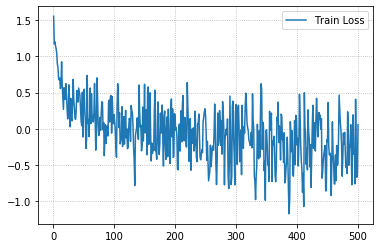

In [19]:
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1,n_epochs+1), np.log10(history), label="Train Loss")
plt.legend()

In [20]:
def f(data):
    # Corresponds to G(x, w) from the notes, mean of gaussian likelihood
    pred_mean = network(data).detach().reshape(1,-1)[0]
    return pred_mean

In [21]:
 # Define the prior and the likelihood according to pyro syntax
mu_prior = 12.
sigma_prior = 4 #np.sqrt(4)
sigma_likelihood = 0.075 #np.sqrt(0.075)


def model(t, T):
    # Prior is a gaussian distriubtion with mean 0 and standard deviation 0.1
    prior_u = dist.Normal(mu_prior, sigma_prior)
    u = pyro.sample("u", prior_u)
    u = u.expand(t.shape[0], 1)
    inputs = torch.cat([t, u], 1)
    mean = f(inputs)
    # Likelihood is a gaussian distriubtion with mean G(x,w)=wx and standard deviation 0.1
    likelihood = dist.Normal(mean, sigma_likelihood)
    u_sampled = pyro.sample("obs", likelihood, obs=T)

In [22]:
n_samples = 10000

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=n_samples, warmup_steps=500, initial_params={"u": torch.tensor(mu_prior)})
mcmc.run(torch.Tensor(measured_data.loc[:,0].values.reshape(-1,1)), torch.Tensor(measured_data.loc[:,1].values))
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 10500/10500 [13:01:29,  4.47s/it, step size=2.45e-03, acc. prob=0.733] 


Text(0.5, 1.0, 'MCMC Trace')

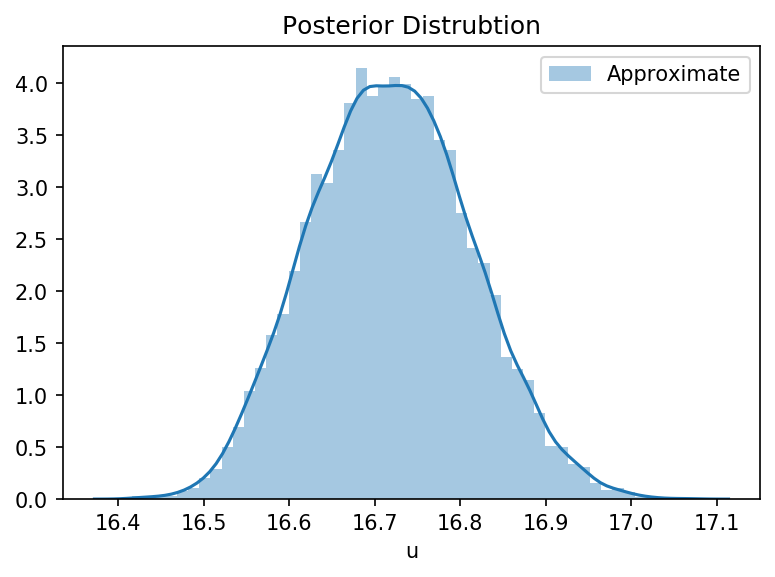

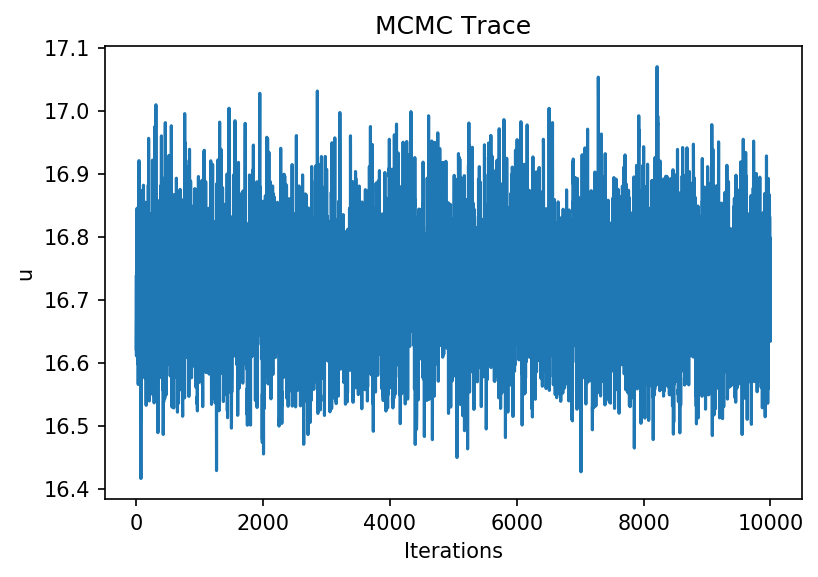

In [23]:
plt.figure(dpi=150)
sns.distplot(hmc_samples["u"], label="Approximate", norm_hist=True)
plt.xlabel("u")
plt.title("Posterior Distrubtion")
plt.legend()
plt.figure(dpi=150)
plt.plot(np.arange(0, hmc_samples["u"].shape[0]), hmc_samples["u"], label="MCMC")
plt.ylabel("u")
plt.xlabel("Iterations")
plt.title("MCMC Trace")

In [28]:
np.savetxt('/Users/chenyilu/SynologyDrive/ETH2_2/DLSC/projects/Project2B 2/Task4/Task4c.txt', hmc_samples["u"])